# LSTM neural network for time series prediction

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable 
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

We load and plot Tesla stock data from 2010 to 2020

In [2]:
tesla_data = pd.read_csv('TSLA_2010_2020.csv')
tesla_data = tesla_data.drop(['Date','Open','High','Low','Close','Volume'],axis = 1)
total_days = tesla_data.shape[0]
tesla_data.head()

,Adj Close
0,23.889999
1,23.830000
2,21.959999
3,19.200001
4,16.110001


<Figure size 432x288 with 0 Axes>

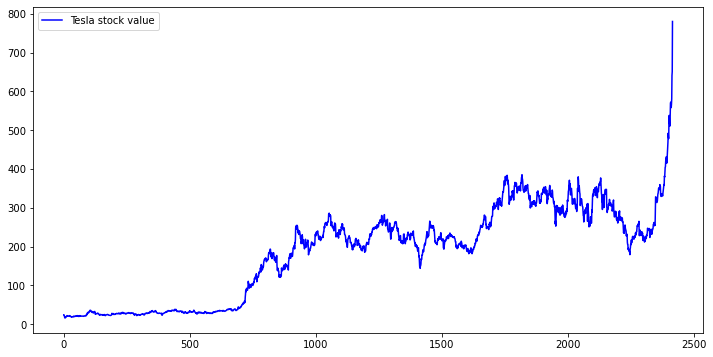

In [3]:
plt.clf()
plt.figure(figsize=(12,6))
plt.plot(tesla_data, label='Tesla stock value', c = 'b')
plt.legend()
plt.show() 

We define a class LSTM_nn which is a neural network with LSTM layers

In [20]:
class LSTM_nn(nn.Module):
    def __init__(self,input_size, num_layers, hidden_size, seq_length):
        super(LSTM_nn, self).__init__()
        #Attributes from nn.Module
        self.input_size = input_size #input size
        self.num_layers = num_layers #number of layers
        self.hidden_size = hidden_size #hidden state
        
        #New attributes
        self.seq_length = seq_length #sequence length
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first = True) #lstm
        
        self.fc =  nn.Linear(hidden_size, 1) #fully connected linear


    def forward(self,X):
        h_0 = Variable(torch.zeros(self.num_layers, X.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, X.size(0), self.hidden_size)) #internal state
        
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(X, (h_0, c_0)) #lstm with input, hidden, and internal state
        final_state = hn.view(self.num_layers, X.size(0), self.hidden_size)[-1]
                
        # Propagate input through fully connected linear neuron
        out = self.fc(final_state)
        
        return out
    
    
    def _train(self, num_epochs, learning_rate, criterion, X_train, y_train, X_test, y_test):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate) 
        t = trange(num_epochs+1)
        for epoch in t:
            #Pass through the neural network
            train_outputs = self.forward(X_train) 
            test_outputs = self.forward(X_test) 

            #Reset gradients to zero  
            optimizer.zero_grad() 

            train_loss = criterion(train_outputs, y_train)
            test_loss = criterion(test_outputs,y_test)

            #Backprogagation step
            train_loss.backward()

            #Update weights and bias of the network
            optimizer.step()

            #Print train and test loss
            t.set_description("Epoch: %d, Train loss: %1.5f, Test loss: %1.5f" % (epoch, train_loss.item(),test_loss.item()))
    
    def get_accuracy(self, X_data, y_data, naive_prediction, scaler, last_day):
        lstm_prediction = scaler.inverse_transform(self(X_data).detach().numpy())
        real_values = scaler.inverse_transform(y_data.numpy())

        naive_error = mean_squared_error(real_values[:last_day:1],naive_prediction[:last_day:1])
        lstm_error = mean_squared_error(real_values[:last_day:1],lstm_prediction[:last_day:1])

        naive_r2 = r2_score(real_values[:last_day:1], naive_prediction[:last_day:1])
        lstm_r2 = r2_score(real_values[:last_day:1], lstm_prediction[:last_day:1])

        print('Mean squared error up to the ' + str(last_day) + ' day using the naive prediction : ' + str(naive_error))
        print('Mean squared error up to the ' + str(last_day) + ' day using the lstm prediction : ' + str(lstm_error))
        print('R2 up to the ' + str(last_day) + ' day using the naive prediction : ' + str(naive_r2))
        print('R2 up to the ' + str(last_day) + ' day using the lstm prediction : ' + str(lstm_r2))
        
    def plot(self, X_data, y_data, scaler):
        lstm_prediction = scaler.inverse_transform(self(X_data).detach().numpy())
        real_values = scaler.inverse_transform(y_data.numpy())
        plt.clf()
        plt.figure(figsize=(12,6))
        plt.plot(real_values, label='Actual value', c = 'b')
        plt.plot(lstm_prediction, label='LSTM Prediction', c = 'r')
        plt.legend()
        plt.show() 
        

We define a sliding windows function that takes the previous days as features and the current day as target

In [7]:
def sliding_windows(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length-1):
        Xi = data[i:(i+seq_length)]
        yi = data[i+seq_length]
        X.append(Xi)
        y.append(yi)
    return np.array(X),np.array(y)

We define a process function

In [8]:
def process_data(data, seq_length, train_proportion, scaler):
    data = np.array(data)
    
    #Fitting on training data
    train_size = int(len(data) * train_proportion)
    scaler.fit(data[0:train_size])
    
    #Transforming all data
    data_normalized = scaler.transform(data)
    X,y = sliding_windows(data_normalized,seq_length)
    
    #All data
    X_data = Variable(torch.Tensor(X))
    y_data = Variable(torch.Tensor(y))
    
    #Training 
    X_train = Variable(torch.Tensor(X[0:train_size]))
    y_train = Variable(torch.Tensor(y[0:train_size]))
    
    #Testing
    X_test = Variable(torch.Tensor(X[train_size:len(X)]))
    y_test = Variable(torch.Tensor(y[train_size:len(X)]))

    return data_normalized, X_data, y_data, X_train, y_train, X_test, y_test

We define a process function with a difference step to avoid prediction based on autocorrelation

In [9]:
def process_data_diff(data, seq_length, train_proportion, scaler):
    data = np.array(data)
    
    #Differentiating the time series
    data_diff = np.diff(data.reshape(data.shape[0])).reshape(-1,1)

    #Fitting on training data
    train_size = int(len(data_diff) * train_proportion)    
    scaler.fit(data_diff[0:train_size])
    
    #Transforming all data
    data_normalized = scaler.transform(data_diff)
    X,y = sliding_windows(data_normalized,seq_length)
    
    #All data
    X_data = Variable(torch.Tensor(X))
    y_data = Variable(torch.Tensor(y))
    
    #Training 
    X_train = Variable(torch.Tensor(X[0:train_size]))
    y_train = Variable(torch.Tensor(y[0:train_size]))
    
    #Test
    X_test = Variable(torch.Tensor(X[train_size:len(X)]))
    y_test = Variable(torch.Tensor(y[train_size:len(X)]))

    return data_normalized, X_data, y_data, X_train, y_train, X_test, y_test

We process our data two times

In [10]:
seq_length = 15
train_proportion = 2/3
scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler2 = MinMaxScaler(feature_range=(-1, 1))

data_normalized1, X_data1, y_data1, X_train1, y_train1, X_test1, y_test1 = process_data(tesla_data, seq_length, train_proportion, scaler1)
data_normalized2, X_data2, y_data2, X_train2, y_train2, X_test2, y_test2 = process_data_diff(tesla_data, seq_length, train_proportion, scaler2)

We create two recurrent neural network with our LSTM_nn class

In [21]:
my_model1 = LSTM_nn(input_size = 1, num_layers = 1, hidden_size = 21, seq_length = seq_length)
my_model2 = LSTM_nn(input_size = 1, num_layers = 1, hidden_size = 21, seq_length = seq_length)

We train our first model with the raw data

In [12]:
num_epochs = 500
learning_rate = 0.001
criterion = nn.MSELoss()
my_model1._train(num_epochs, learning_rate, criterion, X_train1, y_train1, X_test1, y_test1)

Epoch: 500, Train loss: 0.00285, Test loss: 0.08900: 100%|██████████| 501/501 [00:25<00:00, 19.96it/s]


We train our second model with the differenciated data

In [40]:
num_epochs = 8000
learning_rate = 0.001
criterion = nn.MSELoss()    
my_model2._train(num_epochs, learning_rate, criterion, X_train2, y_train2, X_test2, y_test2)

Epoch: 8000, Train loss: 0.00169, Test loss: 0.25946: 100%|██████████| 8001/8001 [06:46<00:00, 19.68it/s]


Use this to save our models parameters for future use

In [41]:
filepath1 = 'lstm1'
filepath2 = 'lstm2'
torch.save(my_model1.state_dict(), filepath1)
torch.save(my_model2.state_dict(), filepath2)

Use this to load saved parameters

In [22]:
filepath1 = 'lstm1'
filepath2 = 'lstm2'
my_model1.load_state_dict(torch.load(filepath1))
my_model2.load_state_dict(torch.load(filepath2))

<All keys matched successfully>

We compare our predictions and the naive prediction $\hat{y}(t+1 | t) = y(t)$ with a MAE loss.

In [43]:
last_day = 1600
print('First model accuracy :')
naive_prediction1 = scaler1.inverse_transform(X_data1.numpy()[:,my_model1.seq_length-1])
my_model1.get_accuracy(X_data1, y_data1, naive_prediction1, scaler1, last_day)
print('\n')
print('Second model accuracy :')
naive_prediction2 = np.zeros(y_data2.size(0))
my_model2.get_accuracy(X_data2, y_data2, naive_prediction2, scaler2, last_day)

First model accuracy :
Mean squared error up to the 1600 day using the naive prediction : 19.273535
Mean squared error up to the 1600 day using the lstm prediction : 52.146095
R2 up to the 1600 day using the naive prediction : 0.9977918637335024
R2 up to the 1600 day using the lstm prediction : 0.9940257102255287


Second model accuracy :
Mean squared error up to the 1600 day using the naive prediction : 19.281233222972233
Mean squared error up to the 1600 day using the lstm prediction : 1.3391609
R2 up to the 1600 day using the naive prediction : -0.0006310232162451967
R2 up to the 1600 day using the lstm prediction : 0.9305020574948696


We make prediction on all data and compare it with actual data.

<Figure size 432x288 with 0 Axes>

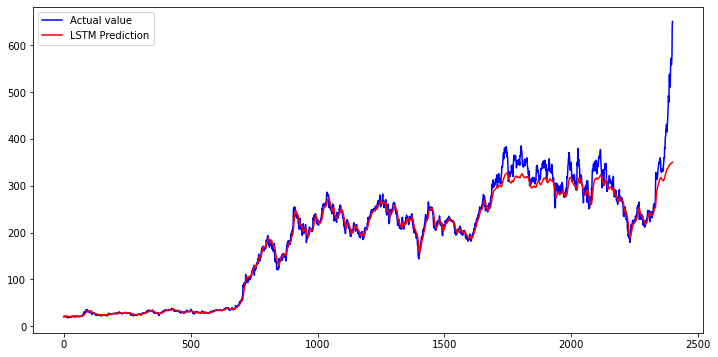

In [29]:
my_model1.plot(X_data1, y_data1, scaler1)

<Figure size 432x288 with 0 Axes>

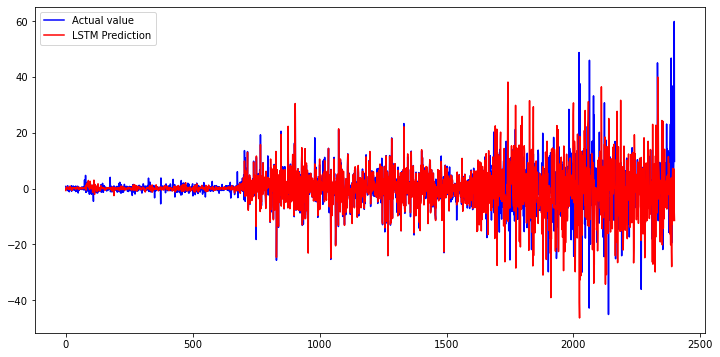

In [44]:
my_model2.plot(X_data2, y_data2, scaler2)